# Resultados preliminares

**Author** Felipe U.

Librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

plt.style.use(['seaborn', "seaborn-dark"][0])
plt.rc('axes', titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams.update({'lines.markeredgewidth': 1})
plt.rcParams.update({'errorbar.capsize': 2})

from sklearn.datasets import make_moons, make_circles, make_classification
from scipy.optimize import minimize

# Datasets

In [2]:
def plot_dataset(X, y, name):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap="RdYlBu");
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"{name} dataset");

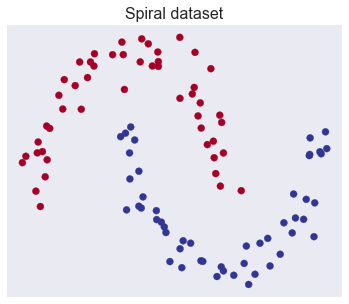

In [3]:
dataset_spiral = make_moons(n_samples=100, noise=0.1, random_state=0)
plot_dataset(dataset_spiral[0], dataset_spiral[1], "Spiral")

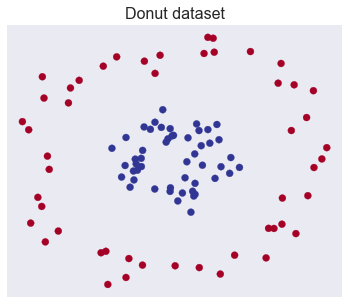

In [4]:
dataset_donut = make_circles(noise=0.1, factor=0.3, random_state=1)
plot_dataset(dataset_donut[0], dataset_donut[1], "Donut")

# Control

In [5]:
[1, 2, 3][:3]

[1, 2, 3]

In [6]:
def dynamic(control, X):
    O = []
    T = []
    for k in range(X.shape[0]):
        x0 = X[k]
        xn = x0.copy()
        x = [xn]
        for i in range(num_layers):
            ix = (dimension*(dimension+1)+1)*i
            jx = ix+dimension*dimension
            zx = jx+dimension
            K = control[ix:jx]
            be = control[jx:zx]
            Dt = control[zx]
            KK = np.array([
                [K[0], K[1]],
                [K[2], K[3]]
            ])
            xn = (xn + Dt*activation_function(KK@xn + be)).copy()
            xn = xn
            x.append(xn)

        ix = dimension*(dimension+1)
        jx = -ix+dimension*dimension
        W = control[-ix:jx]
        mu = control[jx:]
        WW = np.array([
            [W[0], W[1]],
            [W[2], W[3]]
        ]) 
        xf = (WW@xn + mu).copy()
        x.append(xf)
        T.append(x)
        sxf = np.exp(xf)
        sxf /= sum(sxf)
        o = sxf[1]
        O.append(o)
    O = np.array(O)
    return O, T

In [7]:
def obj(control, X, y):
    O, _ = dynamic(control, X)
    L = y[:O.shape[0]]
    Dts = []
    for i in range(num_layers):
        ix = (dimension*(dimension+1)+1)*i
        jx = ix+dimension*dimension
        zx = jx+dimension
        Dt = control[zx]
        Dts.append(Dt)
    Dts = np.array(Dts)
    return 0.5*sum((O-L)*(O-L))

In [8]:
def get_cls(control):
        ix = dimension*(dimension+1)
        jx = -ix+dimension*dimension
        W = control[-ix:jx]
        mu = control[jx:]
        WW = np.array([
            [W[0], W[1]],
            [W[2], W[3]]
        ]) 
        return WW, mu

In [9]:
def clf_cls(x, WW, mu):
    o = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        xf = WW@x[i]+mu
        sxf = np.exp(xf)
        sxf /= sum(sxf)
        o[i] = sxf[1]
    return o

In [10]:
def clf(x, control):
    O, _ = dynamic(control, x)
    return O

In [11]:
def plot_iterations(num_layers, T, y, WW, mu):
    fig, ax = plt.subplots(1, num_layers+1, figsize=(6*(num_layers+1), 5))
    h=0.1
    for i in range(0,num_layers+1):
        Xi = np.array(T)[:, i, :]
        x_min, x_max = Xi[:,0].min()-1, Xi[:,0].max()+1
        y_min, y_max = Xi[:,1].min()-1, Xi[:,1].max()+1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        Z = clf_cls(np.c_[xx.ravel(), yy.ravel()], WW, mu)
        Z = Z.reshape(xx.shape)
        ax[i].contourf(xx, yy, Z, cmap="RdYlBu", alpha=0.5)
        ax[i].scatter(Xi[:,0], Xi[:,1], c=y, cmap="RdYlBu")
        ax[i].set_xticks([])
        ax[i].set_yticks([]);
        ax[i].set_title(f"Iteration: {i}");

In [12]:
def plot_region(X, y, control, model=""):
    fig, ax = plt.subplots(1, 1, figsize=(6*1, 5))
    h=0.1
    Xi = X
    x_min, x_max = Xi[:,0].min()-1, Xi[:,0].max()+1
    y_min, y_max = Xi[:,1].min()-1, Xi[:,1].max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf(np.c_[xx.ravel(), yy.ravel()], control)
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap="RdYlBu", alpha=0.5)
    ax.scatter(Xi[:,0], Xi[:,1], c=y, cmap="RdYlBu")
    ax.set_xticks([])
    ax.set_yticks([]);
    ax.set_title(model, fontsize=24);
    ax.set_ylabel("Predicción", fontsize=24)

In [13]:
def plot_transformation(T, y, WW, mu, model=""):
    fig, ax = plt.subplots(1, 1, figsize=(6*1, 5))
    h=0.1
    i = -2
    Xi = np.array(T)[:, i, :]
    x_min, x_max = Xi[:,0].min()-1, Xi[:,0].max()+1
    y_min, y_max = Xi[:,1].min()-1, Xi[:,1].max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
    Z = clf_cls(np.c_[xx.ravel(), yy.ravel()], WW, mu)
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap="RdYlBu", alpha=0.5)
    ax.scatter(Xi[:,0], Xi[:,1], c=y, cmap="RdYlBu")
    ax.set_xticks([])
    ax.set_yticks([]);
    ax.set_title(model, fontsize=24);
    ax.set_ylabel("Transformación", fontsize=24)

# Resultados

In [14]:
dimension = 2
num_layers = 15
activation_function = lambda x: np.tanh(x)
dt = 1/num_layers

In [15]:
control_0 = []
for i in range(num_layers):
    K = [1,0,0,1]
    be = [0,0]
    Dt = [dt]
    control_0 += K+be+Dt
W = [1,0,0,1]
mu = [0,0]
control_0 += W+mu

control_0 = np.array(control_0)
control_0;

In [16]:
%%time
X, y = dataset_spiral
sol_spiral = minimize(obj, x0=control_0, args=(X, y))
optimal_control_spiral = sol_spiral.x
O_spiral, T_spiral = dynamic(optimal_control_spiral, X)
WW_spiral, mu_spiral = get_cls(optimal_control_spiral)

CPU times: total: 34.8 s
Wall time: 27.1 s


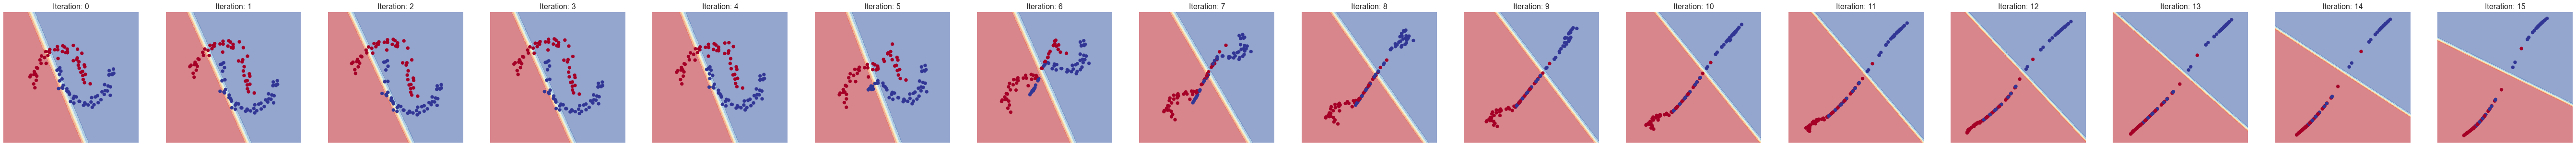

In [17]:
plot_iterations(num_layers, T_spiral, dataset_spiral[1], WW_spiral, mu_spiral)

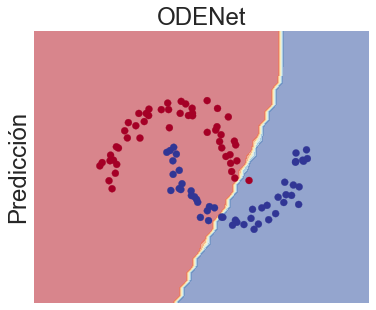

In [18]:
plot_region(dataset_spiral[0], dataset_spiral[1], optimal_control_spiral, model="ODENet")
plt.savefig("p_odenet_dt1.pdf", bbox_inches='tight', )

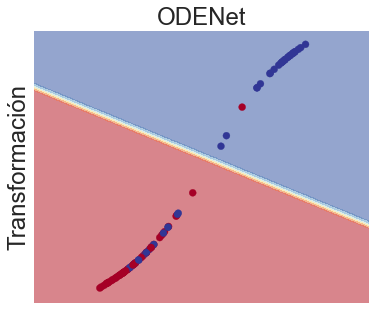

In [19]:
plot_transformation(T_spiral, dataset_spiral[1], WW_spiral, mu_spiral, model="ODENet")
plt.savefig("t_odenet_dt1.pdf", bbox_inches='tight', )

In [20]:
%%time
X, y = dataset_donut
sol_donut = minimize(obj, x0=control_0, args=(X, y))
optimal_control_donut = sol_donut.x
O_donut, T_donut = dynamic(optimal_control_donut, X)
WW_donut, mu_donut = get_cls(optimal_control_donut)

KeyboardInterrupt: 

In [21]:
plot_iterations(num_layers, T_donut, dataset_donut[1], WW_donut, mu_donut)

NameError: name 'T_donut' is not defined

In [ ]:
plot_region(dataset_donut[0], dataset_donut[1], optimal_control_donut, model="ODENet")
plt.savefig("p_odenet_dt2.pdf", bbox_inches='tight', )

In [ ]:
plot_transformation(T_donut, dataset_donut[1], WW_donut, mu_donut, model="ODENet")
plt.savefig("t_odenet_dt2.pdf", bbox_inches='tight', )